### Interpolating with Radial basis functions

Some progress with the programming so far. I tried 2 different RBFs to interpolate a function in 2D. I also investigated the condition number of the system as the number of collocation points increases.    

The interpolating function takes the following form:
$$
\mathcal{P}_f(\boldsymbol{x})=\sum_{k=1}^N c_k \varphi\left(\left\|\boldsymbol{x}-\boldsymbol{x}_k\right\|_2\right), \quad \boldsymbol{x} \in \mathbb{R}^s
$$
To calculate coefficients $c_k$, this function is evaluated at collocation points $x_k$(with coinside with the centers of radial basis functions)

The resulting system looks like this:

$$
\left[\begin{array}{cccc}
\varphi\left(\left\|\boldsymbol{x}_1-\boldsymbol{x}_1\right\|_2\right) & \varphi\left(\left\|\boldsymbol{x}_1-\boldsymbol{x}_2\right\|_2\right) & \ldots & \varphi\left(\left\|\boldsymbol{x}_1-\boldsymbol{x}_N\right\|_2\right) \\
\varphi\left(\left\|\boldsymbol{x}_2-\boldsymbol{x}_1\right\|_2\right) & \varphi\left(\left\|\boldsymbol{x}_2-\boldsymbol{x}_2\right\|_2\right) & \ldots & \varphi\left(\left\|\boldsymbol{x}_2-\boldsymbol{x}_N\right\|_2\right) \\
\vdots & \vdots & \ddots & \vdots \\
\varphi\left(\left\|\boldsymbol{x}_N-\boldsymbol{x}_1\right\|_2\right) & \varphi\left(\left\|\boldsymbol{x}_N-\boldsymbol{x}_2\right\|_2\right) & \ldots & \varphi\left(\left\|\boldsymbol{x}_N-\boldsymbol{x}_N\right\|_2\right)
\end{array}\right]\left[\begin{array}{c}
c_1 \\
c_2 \\
\vdots \\
c_N
\end{array}\right]=\left[\begin{array}{c}
f\left(\boldsymbol{x}_1\right) \\
f\left(\boldsymbol{x}_2\right) \\
\vdots \\
f\left(\boldsymbol{x}_N\right)
\end{array}\right]
$$

In [1]:
using CairoMakie
using Distances
using LinearAlgebra 
using GLMakie

In [2]:
function random_collocation_points(N,x1,x2,y1,y2)
    # generates N 2D points in a rectange between x1 x2 and y1 y2 
    list = rand(Float64,(2,N))
    list[1,:]*= (x2-x1)
    list[2,:]*= (y2-y1)
    list[1,:]= list[1,:] .+x1
    list[2,:]= list[2,:] .+y1
    return list
end


random_collocation_points (generic function with 1 method)

#### Generating a random distribution on the unit square  

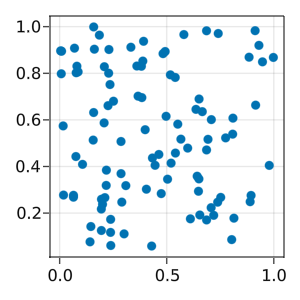

In [3]:
r_points = random_collocation_points(100,0,1,0,1)
f = Figure(resolution = (300, 300))
ax = Axis(f[1, 1])
scatter!(ax,r_points[1,:], r_points[2,:])
f

In [4]:

function linear(r,ϵ) # Linear RBF
    return abs(r)
end
function gaussian(r,ϵ) # guassian RBF
    return exp(-1*r*r*ϵ*ϵ)
end
function sinusoid(x,y,period) # random function for interpolation
    return sin(2*x*π/period)*sin(2*y*π/period)
end
function frankes_func(x,y) # literature standard benchmark for interpolation
    f1 = 0.75*exp(-((9*x.-2).^2 + (9*y.-2).^2)/4)
    f2 = 0.75*exp((-1/49)*(9*x+1).^2 - (1/10)*(9*y+1).^2)
    f3 =0.5*exp((-1/4)*((9*x-7).^2 + (9*y-3).^2))
    f4 = 0.2*exp(-(9*x-4).^2 - (9*y-7).^2)
    return f1+f2+f3-f4
end

frankes_func (generic function with 1 method)

Guassians are the most common choice for RBFs.Shape parameter $\epsilon$ can be chosen arbitrary(the system is non-singular for any choice exept 0), but it will influence the condition number of the interpolation matrix 

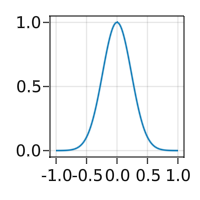

In [14]:
# plot for shape parameter 5
r = collect(LinRange(-1, 1, 1000))
y = gaussian.(r,3)
f2 = Figure(resolution = (200, 200))
ax2 = Axis(f2[1, 1])
lines!(ax2, r, y)
f2

In [6]:

function generate_interpolating_function(coll_points,interpolation_val,basis_function,param)
    N = size(coll_points)[2]
    A = pairwise(Euclidean(), coll_points, coll_points, dims=2)
    A = basis_function.(A,param) # apply RBF to a distance matrix
    coeff = inv(A) * interpolation_val # find coefficients
    function interpolating(x,y)# construct interpolating function
        return sum(coeff .* basis_function.(pairwise(Euclidean(), coll_points, transpose([x y]), dims=2),param))
    end
    return interpolating
end

generate_interpolating_function (generic function with 1 method)

In [7]:
# test function
x = LinRange(0,1,100)
y = LinRange(0,1,100)
x = vec(ones(100) * x') 
y = vec(y * ones(100)')
frankes = frankes_func.(x,y)
gaus_RBF = generate_interpolating_function(r_points,frankes_func.(r_points[1,:],r_points[2,:]),gaussian,5)
linear_RBF = generate_interpolating_function(r_points,frankes_func.(r_points[1,:],r_points[2,:]),linear,0)

(::var"#interpolating#1"{Matrix{Float64}, typeof(linear), Int64, Vector{Float64}}) (generic function with 1 method)

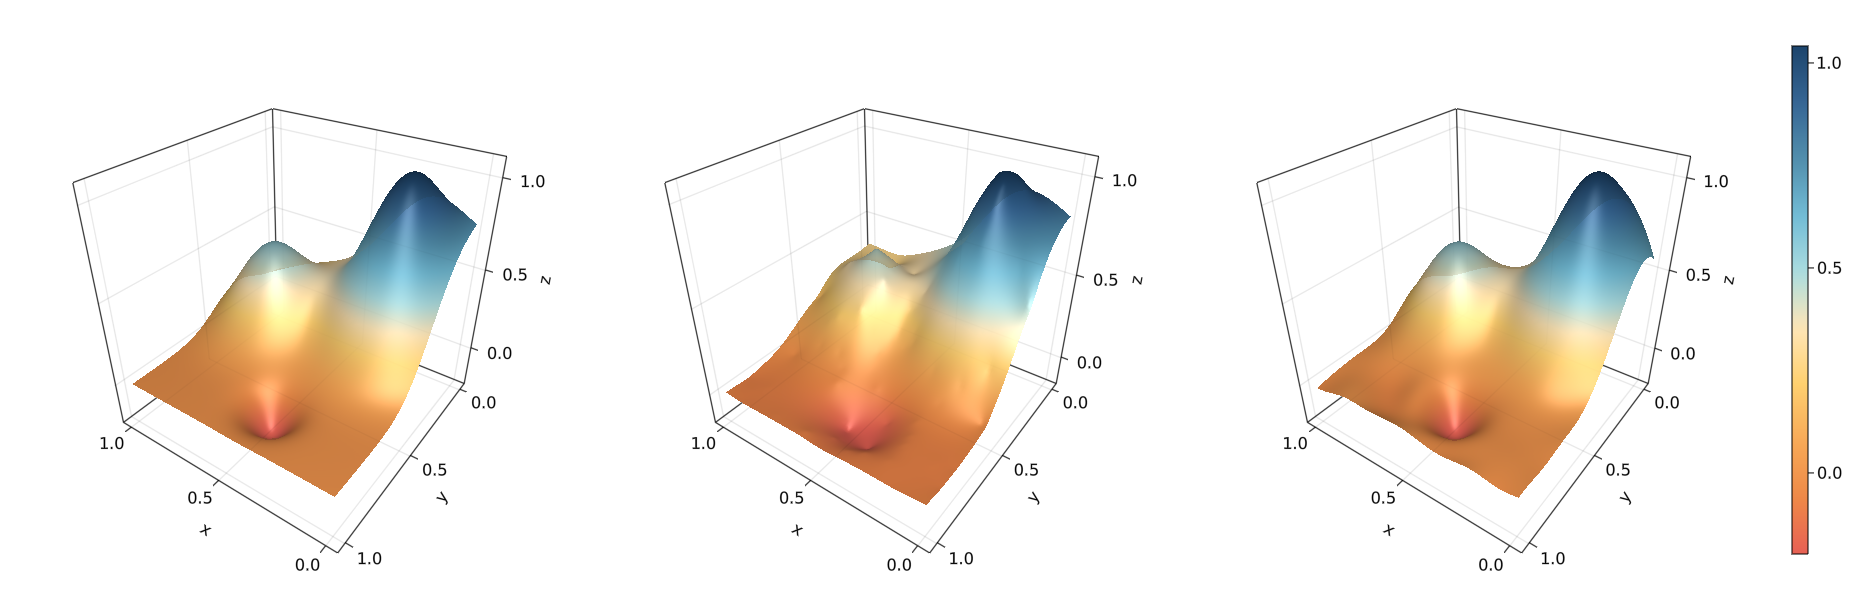

In [8]:

set_theme!(colormap = :Hiroshige)
fig = Figure()
ax1 = Axis3(fig[1, 1]; aspect = (1, 1, 1),
    perspectiveness = 0.5, azimuth = 2.19, elevation = 0.57)
ax2 = Axis3(fig[1, 2]; aspect = (1, 1, 1),
    perspectiveness = 0.5, azimuth = 2.19, elevation = 0.57)
ax3 = Axis3(fig[1, 3]; aspect = (1, 1, 1),
    perspectiveness = 0.5, azimuth = 2.19, elevation = 0.57)

pltobj = surface!(ax1, x, y, frankes; transparency = true)

surface!(ax2, x, y, linear_RBF.(x,y); transparency = true)

surface!(ax3, x, y, gaus_RBF.(x,y); transparency = true)


Colorbar(fig[1, 4], pltobj)
colsize!(fig.layout, 1, Aspect(1, 1.0))
colsize!(fig.layout, 2, Aspect(1, 1.0))
colsize!(fig.layout, 3, Aspect(1, 1.0))
resize_to_layout!(fig)
#save("./assets/simpleLayout.png", fig)
fig

Original function vs linear RBF vs Gaussian RBF

### Condition number vs number of points 
For this I use Halton points rather than random ones because random points can spawn too close giving numerical istabilities which are not related to the thing I'm trying to test. Halton points are more spaced out.


In [9]:
using FastHalton

In [10]:

function generate_2D_Halton_points(N) # 2-3 Halton sequence looks random enough 
    list = zeros(Float64,(2,N))
    list[1,:] = collect(HaltonSeq(2, N,0 ))
    list[2,:] = collect(HaltonSeq(3, N,0 ))
    return float(list)
end
function condition_number(N,RBF,shape_parameter)
    coll_points = generate_2D_Halton_points(N)
    A = pairwise(Euclidean(), coll_points, coll_points, dims=2)
    A = RBF.(A,shape_parameter)
    #println(cond(A))
    return cond(A)
end
condition_number(100,gaussian,5)  # test the function   

1.1568524909207344e6

Example of 200 Halton points in 2D

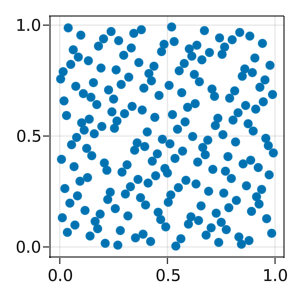

In [11]:
h_points = generate_2D_Halton_points(200)
f = Figure(resolution = (300, 300))
ax = Axis(f[1, 1])
scatter!(ax,h_points[1,:], h_points[2,:])
f

#### What happens to the condition number with increasing number of collocation points

[10, 29, 49, 68, 88, 107, 127, 146, 166, 185, 205, 224, 244, 263, 283, 302, 322, 341, 361, 380, 400]


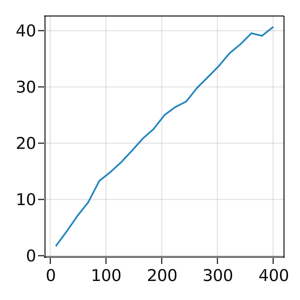

In [12]:
n_list = [10,50,100,200,500,1000]
n_list = (floor.(Int64,collect(LinRange(10,400,21))))
yyy = (condition_number.(n_list,gaussian,5))
println(n_list)
f = Figure(resolution = (300, 300))
ax = Axis(f[1, 1])
lines!(ax,n_list, log.(yyy))
f

Log of Condition number vs number of collocation points keeping the shape parameter constant 


##### Now the same experiment, but the shape parameter is proportional to the number of points 

[5, 5, 5, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[10, 29, 49, 68, 88, 107, 127, 146, 166, 185, 205, 224, 244, 263, 283, 302, 322, 341, 361, 380, 400]


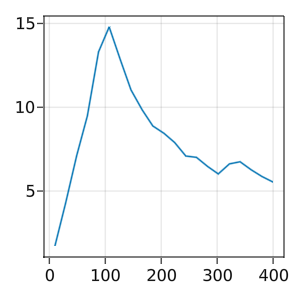

In [13]:
shape_par = max.(n_list.÷20,5)
println(shape_par)
yyy2 = (condition_number.(n_list,gaussian,shape_par))
println(n_list)
f22 = Figure(resolution = (300, 300))
ax22 = Axis(f22[1, 1])
lines!(ax22,n_list, log.(yyy2))
f22

Log of Condition number vs number of collocation points adapting the shape parameter to the changing density of points  

### Conclusion 

I have replicated some of the numerical experiments from the literature regarding RBF interpolation. Even though the condition number can be kept low by tweaking the shape parameter, the cost of interpolation increases as O($N^3$) due to inversion of interpolation matrix. 
In the next weeks I will study techniques to reduce the complexity by dividing the domain into smaller regions.
Also, I haven't compared the convergence of different RBFs and different point distributions, I plan to run some numerical experiment later when I cover the theory of RBF errors